In [2]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Read data

In [3]:
df = pd.read_csv("inda_data.csv", sep=";")

df.describe()

,Operation Structuring,Intrinsic operation complexity
count,51.000000,51.000000
mean,7.235792,0.234785
std,1.348033,0.028112
min,4.928571,0.172566
25%,6.245215,0.219237
50%,6.860000,0.233235
75%,8.092311,0.248359
max,10.322917,0.295907


# Make plots

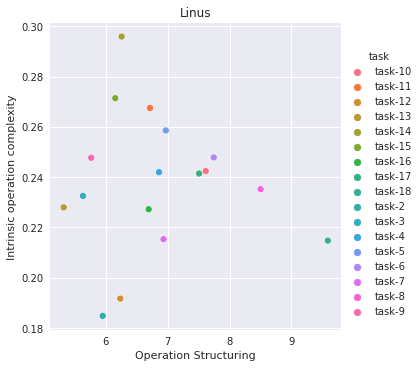

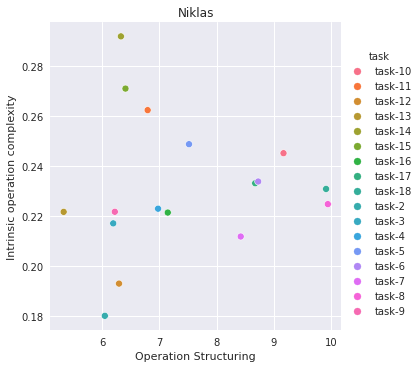

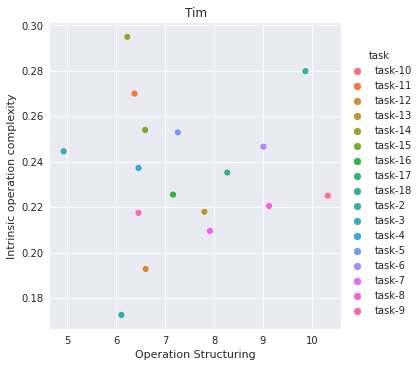

In [4]:
for ta, rows in df.groupby("TA"):
    sn.relplot(data=rows, x="Operation Structuring", y="Intrinsic operation complexity", hue="task")
    plt.title(ta)